# Yelp Multi-Label Classification 

In this exercise, we're going to go up in difficulty and try to enter the [Yelp Kaggle competition](https://www.kaggle.com/c/yelp-restaurant-photo-classification/overview). Yelp would indeed like to see "the atmosphere of a restaurant" from a picture. We can predict the following labels on the image: 

* Good for lunch
* Good for dinner 
* Take reservations 
* Terrace available
* Restaurant is expensive or not
* Serves alcohol 
* Serves at Table 
* The atmosphere is classy 
* Good for the kids. 

Instead of making a classification of only one label (i.e. cat/dog), this time we will have to put several labels on the same picture. So let's see how we can solve this challenge with TensorFlow. 

* Start by installing : 
  * kaggle 

In [ ]:
!pip install kaggle

* For the rest, we'll use the Kaggle API to download data (too large to do otherwise)
  * Go to the Kaggle API and see how to download your `kaggle.json` file: [Kaggle API](https://github.com/Kaggle/kaggle-api)
  * Next, you need to put your `kaggle.json` in the `/root` folder of your Google Colab (or your local machine). 
  * So try to do this using your terminal commands.
  * Here are some reminders 

  

  <img src="https://i.redd.it/rl0fe7r6zku11.jpg" alt="linux cmd" height=700>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir /root/.kaggle
!cp /content/drive/MyDrive/Documents/Data\ Science/Jedha/Thibaud\ Chevrier/FullStack/6-Deep_learning/05-Transfer_Learning/Exercises/kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

* Use the command `!kaggle compilations download -p /content -c yelp-restaurant-photo-classification` to download all the elements 

In [ ]:
import tarfile

!kaggle competitions download -p /content -c yelp-restaurant-photo-classification -f train.csv.tgz

file = tarfile.open("train.csv.tgz", mode="r:gz")
file.extractall()
file.close()

!rm /content/train.csv.tgz

  0% 0.00/7.12k [00:00<?, ?B/s]
100% 7.12k/7.12k [00:00<00:00, 11.2MB/s]


In [ ]:
!rm -rf /content/train_photos
!kaggle competitions download -p /content -c yelp-restaurant-photo-classification -f train_photos.tgz
!unzip /content/train_photos.tgz.zip 
!rm /content/train_photos.tgz.zip

file = tarfile.open("train_photos.tgz", mode="r:gz")
file.extractall()
file.close()

!rm /content/train_photos.tgz

100% 6.54G/6.55G [02:28<00:00, 75.9MB/s]
100% 6.55G/6.55G [02:28<00:00, 47.3MB/s]
Archive:  /content/train_photos.tgz.zip
  inflating: train_photos.tgz        


In [ ]:
!kaggle competitions download -p /content -c yelp-restaurant-photo-classification -f train_photo_to_biz_ids.csv.tgz
!unzip train_photo_to_biz_ids.csv.tgz.zip
!rm /content/train_photo_to_biz_ids.csv.tgz.zip

file = tarfile.open("train_photo_to_biz_ids.csv.tgz", mode="r:gz")
file.extractall()
file.close()

!rm /content/train_photo_to_biz_ids.csv.tgz

  0% 0.00/1.12M [00:00<?, ?B/s]
100% 1.12M/1.12M [00:00<00:00, 80.6MB/s]
Archive:  train_photo_to_biz_ids.csv.tgz.zip
  inflating: train_photo_to_biz_ids.csv.tgz  


* Import librairies bellow: 

  * Pandas 
  * Matplotlib
  * Tensorflow 
  * pathlib
  * from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
import pathlib

* Create a `clean_path_img` function that goes:
  * Create a `Path` object for all images with a `.jpg` extension.
  * Turning `Path` objects into `str` objects
  * Filter all image paths that start with a `.` (these are corrupted images in the dataset).

In [ ]:
from pathlib import Path

def clean_path_img(directory):
    return [str(img_file) for img_file in directory.glob("[!.]*.jpg")]

images_path = clean_path_img(Path("/content/train_photos"))
images_path[:5]

['/content/train_photos/215182.jpg',
 '/content/train_photos/413769.jpg',
 '/content/train_photos/468684.jpg',
 '/content/train_photos/6939.jpg',
 '/content/train_photos/268488.jpg']

* Look at the final size of your dataset 

In [ ]:
len(images_path)

234842

* Now create a `mapping_dataset` function that goes: 
  * Read the two files `train.csv` & `train_photo_to_biz_ids.csv`
  * Merge the two files 
  * Create a column containing all the paths to each of the images corresponding to its label
  * Remove the NaN 
  * Take a sample of 30% of the data (to limit the training time afterwards) 

In [ ]:
def mapping_dataset():
    train = pd.read_csv("/content/train.csv")
    train_photo_to_biz_ids = pd.read_csv("/content/train_photo_to_biz_ids.csv")
    train = train.merge(train_photo_to_biz_ids, left_on='business_id', right_on='business_id')
    train["path"] = train["photo_id"].apply(lambda x: f"/content/train_photos/{x}.jpg")
    train.dropna(inplace=True)
    return train.sample(int(0.3*len(train))).reset_index(drop=True)

train = mapping_dataset() 

In [ ]:
train.head()

,business_id,labels,photo_id,path
0,2298,1 2 3 4 5 6 7,208620,/content/train_photos/208620.jpg
1,2339,1 2 4 5 6,93073,/content/train_photos/93073.jpg
2,396,2 3 5 6 8,359,/content/train_photos/359.jpg
3,2671,1 2 5 6,155384,/content/train_photos/155384.jpg
4,3823,0 6 8,89709,/content/train_photos/89709.jpg


* We're going to have to create one hot encoded versions of our labels. To do this we will need to use the `MultiLabelBinarizer` module from sklearn. So create a function that will : 
  * Create an instance of the `MultiLabelBinarizer`.
  * Fit the instance on our dataset labels 
  * Turn labels into a list of 0 & 1's 

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

def binarize(label):
    mlb = MultiLabelBinarizer()
    return mlb.fit_transform(train["labels"].str.split(" ").to_list())

In [ ]:
label_bin = binarize(train["labels"])

* If you make a loop on the first 10 elements, you will be able to find the labels corresponding to each of the paths of your images. 

In [ ]:
for idx in range(10):
    print(train["path"].iloc[idx], label_bin[idx])

/content/train_photos/208620.jpg [0 1 1 1 1 1 1 1 0]
/content/train_photos/93073.jpg [0 1 1 0 1 1 1 0 0]
/content/train_photos/359.jpg [0 0 1 1 0 1 1 0 1]
/content/train_photos/155384.jpg [0 1 1 0 0 1 1 0 0]
/content/train_photos/89709.jpg [1 0 0 0 0 0 1 0 1]
/content/train_photos/96274.jpg [0 0 0 0 0 0 0 0 1]
/content/train_photos/51547.jpg [1 0 0 1 0 0 0 0 1]
/content/train_photos/335242.jpg [1 0 0 1 0 1 0 0 1]
/content/train_photos/160827.jpg [0 0 0 0 0 0 1 0 1]
/content/train_photos/415441.jpg [0 1 1 0 1 1 1 0 0]


# TensorFlow Dataset 

We will now move on to the creation of the TensorFlow dataset. 

* Create a `parse_function` function that will 
  * Read the paths of each image 
  * Decode the images 
  * Resize images to (224, 224)
  * Divide the tensors by 255

In [ ]:
def parse_function(image_path, label):
    return tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3), [224, 224]) / 255.0, label

* Create a `tf.data.Dataset` containing your image paths and corresponding labels.

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((train["path"].values, label_bin))

In [ ]:
for x, y in dataset.take(1):
    print(x, y)

tf.Tensor(b'/content/train_photos/208620.jpg', shape=(), dtype=string) tf.Tensor([0 1 1 1 1 1 1 1 0], shape=(9,), dtype=int64)


* Make a train / test split 

In [ ]:
# Train / Test split 
split = int(0.75 * len(train))
full_ds = dataset.shuffle(len(train), reshuffle_each_iteration=False)
train_set = full_ds.take(split)
test_set = full_ds.skip(split)

In [ ]:
for x, y in full_ds.take(1):
    print(x, y)

tf.Tensor(b'/content/train_photos/427731.jpg', shape=(), dtype=string) tf.Tensor([0 0 0 0 0 0 1 0 1], shape=(9,), dtype=int64)


- Shuffle your train and your test sets

In [ ]:
train_set = train_set.shuffle(len(train_set))
test_set = test_set.shuffle(len(test_set))

* Then apply your `parse_function` to the train and the test sets

In [ ]:
train_set = train_set.map(parse_function)
test_set = test_set.map(parse_function)

* Create batches of 64 in your train and your test sets

In [ ]:
train_set = train_set.batch(64)
test_set = test_set.batch(64)

* Look at a picture on your train to make sure everything's okay 

tf.Tensor([64  9], shape=(2,), dtype=int32)


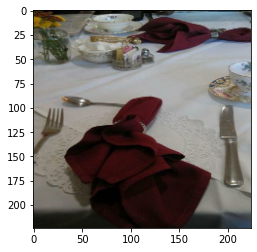

In [ ]:
for x, y in train_set.take(1):
    plt.imshow(x[0])
    print(tf.shape(y))

# Model Architecture

* Create an instance of `tf.distribute.MirrorStrategy`. It's a way to speed up our computing.

In [ ]:
# Distributed Strategy
strategy = tf.distribute.MirroredStrategy(['/job:localhost/replica:0/task:0/device:GPU:0'])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


* Create a pre-trained MobileNetV2 model that you will adapt to your dataset. You will need to wrap a `strategy.scope()` context. I.e 
```
with strategy.scope():

    YOUR MODEL ARCHITECTURE

    YOUR LEARNING RATE SCHEDULER

    YOUR COMPILER
```

In [ ]:
with strategy.scope():
 
  base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), 
                                               include_top=False,
                                               weights="imagenet"
                                               )
  
  model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dense(524, activation="relu"),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(124, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(9, activation="sigmoid")
  ])
 
  initial_learning_rate = 0.0001

  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate,
      decay_steps=2000,
      decay_rate=0.90,
      staircase=True
  )

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
      metrics = [tf.keras.metrics.BinaryAccuracy()]
  )


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 524)               537100    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               134400    
_________________________________________________________________
dense_3 (Dense)              (None, 124)               31868     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8

* Fit your model on 5 to 10 epochs 

**WARNING**: This training will be long! (about 5 min / epochs)

In [ ]:
history = model.fit(train_set, validation_data=test_set, epochs=10)

Epoch 1/10
825/825 [==============================] - 335s 353ms/step - loss: 0.5363 - binary_accuracy: 0.7183 - val_loss: 0.8056 - val_binary_accuracy: 0.6763
Epoch 2/10
825/825 [==============================] - 287s 347ms/step - loss: 0.4291 - binary_accuracy: 0.7903 - val_loss: 0.4757 - val_binary_accuracy: 0.7632
Epoch 3/10
825/825 [==============================] - 289s 350ms/step - loss: 0.3781 - binary_accuracy: 0.8204 - val_loss: 0.4836 - val_binary_accuracy: 0.7650
Epoch 4/10
825/825 [==============================] - 287s 348ms/step - loss: 0.3350 - binary_accuracy: 0.8444 - val_loss: 0.5786 - val_binary_accuracy: 0.7596
Epoch 5/10
825/825 [==============================] - 288s 349ms/step - loss: 0.3037 - binary_accuracy: 0.8615 - val_loss: 0.5481 - val_binary_accuracy: 0.7656
Epoch 6/10
825/825 [==============================] - 286s 347ms/step - loss: 0.2708 - binary_accuracy: 0.8791 - val_loss: 0.5672 - val_binary_accuracy: 0.7631
Epoch 7/10
825/825 [====================

* Visualize your accuracy compared to your epochs on your train & test

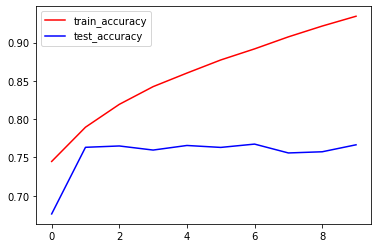

In [ ]:
# Visualise train / Valid Accuracy
plt.plot(history.history["binary_accuracy"], c="r", label="train_accuracy")
plt.plot(history.history["val_binary_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

* Do the same with your `loss`

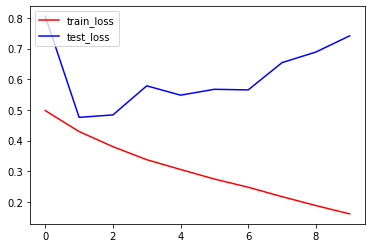

In [ ]:
# Visualise train / Valid Loss
plt.plot(history.history["loss"], c="r", label="train_loss")
plt.plot(history.history["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()

* Unfreeze the last 50 layers of your model. 

In [ ]:
fine_tune_from = -50
for layer in model.layers[fine_tune_from:]:
    layer.trainable = True

* Recompile your model 

In [ ]:
with strategy.scope():
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.BinaryAccuracy()]
    )

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 524)               537100    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               134400    
_________________________________________________________________
dense_3 (Dense)              (None, 124)               31868     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8

* Re-train your model on 5 to 10 epochs

In [ ]:
history = model.fit(train_set, validation_data=test_set, epochs=10)

Epoch 1/10
825/825 [==============================] - 302s 351ms/step - loss: 0.1484 - binary_accuracy: 0.9403 - val_loss: 0.7848 - val_binary_accuracy: 0.7614
Epoch 2/10
825/825 [==============================] - 285s 345ms/step - loss: 0.1362 - binary_accuracy: 0.9458 - val_loss: 0.8425 - val_binary_accuracy: 0.7458
Epoch 3/10
825/825 [==============================] - 285s 345ms/step - loss: 0.1204 - binary_accuracy: 0.9526 - val_loss: 0.8699 - val_binary_accuracy: 0.7513
Epoch 4/10
825/825 [==============================] - 286s 346ms/step - loss: 0.0996 - binary_accuracy: 0.9613 - val_loss: 0.9170 - val_binary_accuracy: 0.7582
Epoch 5/10
825/825 [==============================] - 286s 347ms/step - loss: 0.0869 - binary_accuracy: 0.9663 - val_loss: 0.9384 - val_binary_accuracy: 0.7618
Epoch 6/10
825/825 [==============================] - 287s 347ms/step - loss: 0.0747 - binary_accuracy: 0.9713 - val_loss: 1.0470 - val_binary_accuracy: 0.7584
Epoch 7/10
825/825 [====================

* Make your visualizations 

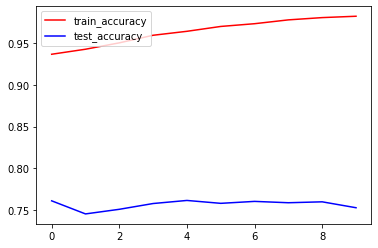

In [ ]:
# Visualise train / Valid Accuracy
plt.plot(history.history["binary_accuracy"], c="r", label="train_accuracy")
plt.plot(history.history["val_binary_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

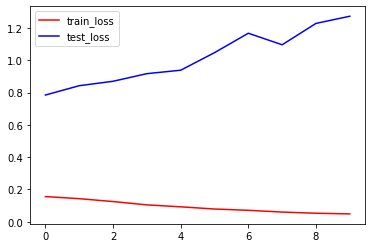

In [ ]:
# Visualise train / Valid Loss
plt.plot(history.history["loss"], c="r", label="train_loss")
plt.plot(history.history["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()

* Look at an example of predictions versus reality 

Preds : [2.8826406e-02 7.1796489e-01 9.9855858e-01 2.5095562e-02 8.4638465e-05
 9.9950492e-01 9.9909127e-01 2.3607008e-01 1.7994408e-01]
Truth : [0 1 1 1 1 1 1 1 0]


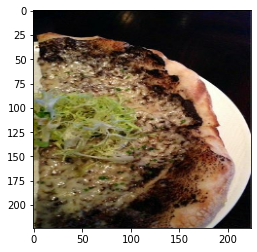

In [ ]:
for x, y in test_set.take(1):
    y_pred = model.predict(x)
    print("Preds : {}\nTruth : {}".format(y_pred[0], y[0].numpy()))
    plt.imshow(x[0])

# To go further 

* [Multi-Label Image Classification in TensorFlow 2.0.ipynb](https://github.com/ashrefm/multi-label-soft-f1/blob/master/Multi-Label%20Image%20Classification%20in%20TensorFlow%202.0.ipynb)

* [Kaggle API](https://github.com/Kaggle/kaggle-api)